# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
# Import libraries
import os
import numpy as np
import tqdm # For showing the progress

# Pytorch
import torch
# Dataset
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
# Model, training
from torch import nn
from torch import optim
import torch.nn.functional as F

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# data_dir = '/data/landmark_images/'
# data_dir = 'C:/Users/BensonHuang/Downloads/landmark_images'
data_dir = '/home/BensonHuang/ml/landmark_images'
#
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# Check if the mentioned path exist
print("Path exist: ", os.path.exists(data_dir), "\n--------------------\n")

# Show the directory tree
#---------------------------------------------#
# Ref.: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python
def list_files(startpath, print_files=True):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        dir_name = os.path.basename(root)
        print('{}{}/{}[# sub-dirs: {}, # files: {}]'.format(indent, dir_name, ' '*max(50-len(dir_name), 1), len(dirs), len(files)))
        subindent = ' ' * 4 * (level + 1)
        if print_files:
            for f in files:
                print('{}{}'.format(subindent, f))
            
# print(list_files(data_dir, print_files=False))
#---------------------------------------------#


Path exist:  True 
--------------------



In [3]:
# The function for getting data loaders
def get_data_loaders(train_valid_dir, test_dir, 
                     transform=transforms.ToTensor(),
                     batch_size=20, 
                     num_workers=0, 
                     valid_size=0.2, 
                     seed=42):
    '''
    This is the function for generating data loaders from image data paths 
    for training, validation, and testing, repectively.
    '''
    
    # load and transform data using ImageFolder
    #-------------------------------------#
    train_valid_data = datasets.ImageFolder(train_valid_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # print out some data stats
    print('Num training/validation images: ', len(train_valid_data))
    print('Num test images: ', len(test_data))
    #-------------------------------------#

    # obtain training indices that will be used for validation
    num_train_valid = len(train_valid_data)
    indices = list(range(num_train_valid))
    # Set a fixed seed so that the validation set is the same every time I run the script.
    np.random.seed(seed) 
    np.random.shuffle(indices)
    #
    split = int(np.floor(valid_size * num_train_valid))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_valid_data, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_valid_data, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=False)
    #-------------------------------------#

    return train_valid_data, test_data, {'train': train_loader, 'valid': valid_loader, 'test': test_loader} 


In [4]:
# Generate the data loaders
#------------------------------------------------------------#

# Data transform
#-----------------------------#
# VGG-16 Takes 224x224 images as input, so we resize all of them
image_size = 32 # LeNet: 32 # 224
# data_transform = transforms.ToTensor()

# data_transform for training
data_transform_train = transforms.Compose([transforms.RandomResizedCrop(image_size), 
                                           transforms.ToTensor()])
# data_transform for validation and testing
data_transform_test = transforms.Compose([transforms.Resize((image_size,image_size)),
                                          transforms.ToTensor()])
#-----------------------------#
# define dataloader parameters
batch_size = 20
num_workers=0
valid_size = 0.2 # percentage of the dataset to be used for validation

# Generate the data loaders by calling the function
train_valid_data, test_data, loaders_scratch = get_data_loaders(train_dir, test_dir,
                                                                transform=data_transform_train,
                                                                batch_size=batch_size, 
                                                                num_workers=num_workers, 
                                                                valid_size=valid_size, 
                                                                seed=42)

Num training/validation images:  4996
Num test images:  1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

- The resizing is done by utilizing the transforms.RandomResizedCrop method, which crops the image at a random location (within a given area scale ratio) and random aspect ratio before resizing to the asked size output (32x32 here). Since the aspect ratio for cropping is not a fixed value as the one of the asked shape, the image will be randomly stretched. 
- The image shape for the network input is designed to be 32x32, which is the input shape for that the original LeNet-5 asked. Although the resolution is somewhat low for a human to see, the result still meets the requirement.
- There is a light augmentation applied to the dataset via transforms.RandomResizedCrop, which guides the network about the invariances in translation, scale, and aspect ratio. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

['00.Haleakala_National_Park', '01.Mount_Rainier_National_Park', '02.Ljubljana_Castle', '03.Dead_Sea', '04.Wroclaws_Dwarves', '05.London_Olympic_Stadium', '06.Niagara_Falls', '07.Stonehenge', '08.Grand_Canyon', '09.Golden_Gate_Bridge', '10.Edinburgh_Castle', '11.Mount_Rushmore_National_Memorial', '12.Kantanagar_Temple', '13.Yellowstone_National_Park', '14.Terminal_Tower', '15.Central_Park', '16.Eiffel_Tower', '17.Changdeokgung', '18.Delicate_Arch', '19.Vienna_City_Hall', '20.Matterhorn', '21.Taj_Mahal', '22.Moscow_Raceway', '23.Externsteine', '24.Soreq_Cave', '25.Banff_National_Park', '26.Pont_du_Gard', '27.Seattle_Japanese_Garden', '28.Sydney_Harbour_Bridge', '29.Petronas_Towers', '30.Brooklyn_Bridge', '31.Washington_Monument', '32.Hanging_Temple', '33.Sydney_Opera_House', '34.Great_Barrier_Reef', '35.Monumento_a_la_Revolucion', '36.Badlands_National_Park', '37.Atomium', '38.Forth_Bridge', '39.Gateway_of_India', '40.Stockholm_City_Hall', '41.Machu_Picchu', '42.Death_Valley_National_Pa

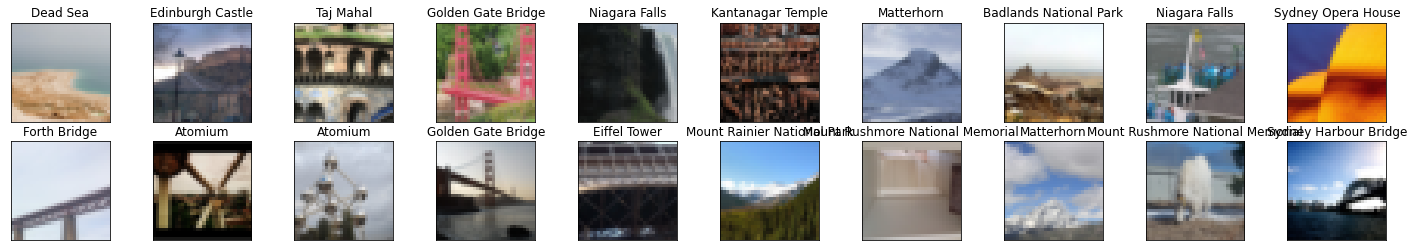

In [5]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

classes_raw = train_valid_data.classes
classes = [' '.join(_c[3:].split('_')) for _c in classes_raw] # Remove the number and replace the '_' by space
num_classes = len(classes)
print(classes_raw)
print()
print("Totally <%d> classes" % num_classes)
print()
# print(classes)
for _i, _c in enumerate(classes):
    print("%2d: %s" % (_i, _c))


# Visualize some training data
# obtain one batch of training images
dataiter = iter( loaders_scratch['train'] )
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

print(f'\nimages[0,0,0,0] = {images[0,0,0,0]}\n')

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0))) # (c,h,w) --> (h,w,c)
    ax.set_title(classes[labels[idx]])

### Initialize use_cuda variable

In [ ]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
print(f'{use_cuda = }')

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [ ]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss() # For scores output
# criterion_scratch = nn.NLLLoss() # For log probabilities output

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.Adam(model.parameters(), lr=0.0001)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [ ]:
# # define the CNN architecture (LeNet5)
# class Net(nn.Module):
#     ## TODO: choose an architecture, and complete the class
#     def __init__(self):
#         super(Net, self).__init__()
        
#         ## Define layers of a CNN
#         self.conv11 = nn.Conv2d(3,  6, 5, padding=0) # 32x32-->28x28
#         # pool
#         self.conv21 = nn.Conv2d(6, 16, 5, padding=0) # 14x14-->10x10
#         # pool
         
#         # FC
#         self.fc1 = nn.Linear(16*5*5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, num_classes)

#         # self.max_pool = nn.MaxPool2d(2,2)
#         self.avg_pool = nn.AvgPool2d(2,2)
#         # self.dropout = nn.Dropout(p=0.3)
        
#     def forward(self, x):
#         ## Define forward behavior
#         x = F.relu(self.conv11(x))
#         x = F.relu(self.avg_pool(x))        
#         x = F.relu(self.conv21(x))
#         x = F.relu(self.avg_pool(x))        
#         # Flatten
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         # x = self.dropout(x) # Dropout
#         x = self.fc3(x) # Scores output
#         # x = F.log_softmax(self.fc3(x), dim=1) # log probabilities output
#         return x

# # define the CNN architecture (ver.2: increase the layer width)
# class Net(nn.Module):
#     ## TODO: choose an architecture, and complete the class
#     def __init__(self):
#         super(Net, self).__init__()
        
#         ## Define layers of a CNN
#         self.conv11 = nn.Conv2d(3,  18, 5, padding=0) # 32x32-->28x28
#         # pool
#         self.conv21 = nn.Conv2d(18, 48, 5, padding=0) # 14x14-->10x10
#         # pool
         
#         # FC
#         self.fc1 = nn.Linear(48*5*5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, num_classes)

#         # self.max_pool = nn.MaxPool2d(2,2)
#         self.avg_pool = nn.AvgPool2d(2,2)
#         # self.dropout = nn.Dropout(p=0.3)
        
#     def forward(self, x):
#         ## Define forward behavior
#         x = F.relu(self.conv11(x))
#         x = F.relu(self.avg_pool(x))        
#         x = F.relu(self.conv21(x))
#         x = F.relu(self.avg_pool(x))        
#         # Flatten
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         # x = self.dropout(x) # Dropout
#         x = self.fc3(x) # Scores output
#         # x = F.log_softmax(self.fc3(x), dim=1) # log probabilities output
#         return x

# define the CNN architecture (ver.3 increase the width further more)
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv11 = nn.Conv2d(3,  36, 5, padding=0) # 32x32-->28x28
        # pool 28x28-->14x14
        self.conv21 = nn.Conv2d(36, 96, 5, padding=0) # 14x14-->10x10
        # pool 10x10-->5x5
         
        # FC
        self.fc1 = nn.Linear(96*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # self.max_pool = nn.MaxPool2d(2,2)
        self.avg_pool = nn.AvgPool2d(2,2)
        # self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv11(x))
        x = F.relu(self.avg_pool(x))        
        x = F.relu(self.conv21(x))
        x = F.relu(self.avg_pool(x))        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = self.dropout(x) # Dropout
        x = self.fc3(x) # Scores output
        # x = F.log_softmax(self.fc3(x), dim=1) # log probabilities output
        return x

    
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

The base architecture I chose is LeNet-5 (https://ieeexplore.ieee.org/document/726791) proposed by Yann LeCun et.al. while most of the designed were simplified: activations changes to ReLUs, feature maps between convolusion layers are fully connected, and the output is the "score" for the softmax activation.
- In version 1, beside the simplification, the input image shape is also change to (32,32,3) for color images. It reached the accuracy about 14%.
- In version 2, I tripled the numbers of feature maps in conv1 and conv2 because of the thought of that the original LeNet-5 designed for the gray image of 1 channel may not be sufficient to contain color features. It reached the accuracy about 18%.
- In version 3, I keep increasing the numbers of feature maps by doubling them. It turns out to reach the accuracy of 22%.

During each version, I tried increasing the depth of comvolution layers or adding dropout at final stage; however, they didn't work in this case.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    valid_loss_min_epoch = -1
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm.tqdm(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Update the train_loss
            train_loss = 1./(batch_idx+1) * (batch_idx*train_loss + loss.data.item())

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            # Update the valid_loss
            valid_loss = 1./(batch_idx+1) * (batch_idx*valid_loss + loss.data.item())

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            valid_loss_min_epoch = epoch
            torch.save(model.state_dict(), save_path)   
            print("Model saved.")
        
        # Early stopping
        patience = 5 # 5
        stop_th = 0.05 # 5%
        if (epoch - valid_loss_min_epoch) > patience:
            print("Out of patience, consider to stop.")
            # Stop the training if the current loss is greater than the threshold, or just keep the training 
            if (valid_loss - valid_loss_min) > (stop_th * valid_loss_min): # stop_th is represented as a ratio
                print("The validation loss jumped across the threshold, stop.")
                break
            else:
                print("The validation loss is not quit big, keep watching")
            
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [ ]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # print("classname = %s" % str(classname))
    # print("classname.find('Linear') = %s" % str(classname.find("Linear")))
    if classname.find("Linear") != -1:
        n = m.in_features
        y = 1.0 / np.sqrt(n)
        m.weight.data.normal_(mean=0.0, std=y)
        m.bias.data.fill_(0.0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [ ]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(tqdm.tqdm(loaders['test'])):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# Generate the data loaders
#------------------------------------------------------------#

# Data transform
#-----------------------------#
# VGG-16 Takes 224x224 images as input, so we resize all of them
image_size = 224 # For VGGNet
# data_transform = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) # Note: pretrained models expects the images to be normalized
# Compose
# data_transform for training
data_transform_train = transforms.Compose([transforms.RandomResizedCrop(image_size), 
                                           transforms.ToTensor(),
                                           normalize])
# data_transform for validation and testing
data_transform_test = transforms.Compose([transforms.Resize((image_size,image_size)),
                                          transforms.ToTensor(),
                                          normalize])
#-----------------------------#
# define dataloader parameters
batch_size = 20
num_workers=0
valid_size = 0.2 # percentage of the dataset to be used for validation

# Generate the data loaders by calling the function
train_valid_data, test_data, loaders_transfer = get_data_loaders(train_dir, test_dir,
                                                                transform=data_transform_train,
                                                                batch_size=batch_size, 
                                                                num_workers=num_workers, 
                                                                valid_size=valid_size, 
                                                                seed=42)


# loaders_transfer = {'train': None, 'valid': None, 'test': None}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [ ]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss() # For scores output


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.Adam(model.parameters(), lr=0.001)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
## TODO: Specify model architecture
print(torch.__version__)


def get_transfered_model_resnet18():
    
    # model_transfer = models.vgg16(pretrained=True)
    model_transfer = models.resnet18(pretrained=True)
    
    # Freeze training for layers
    for param in model_transfer.parameters():
        param.requires_grad = False

    # Modify the fianl stage of the model
    model_transfer.fc = nn.Linear(512, num_classes)
    
    # get the optimizer by passing in the appropriate parameter set
    optimizer = get_optimizer_transfer(model_transfer.fc)
    
    return model_transfer, optimizer

def get_transfered_model_mobilenet_v2():
    
    model_transfer = models.mobilenet_v2(pretrained=True)
    
    # Freeze training for layers
    for param in model_transfer.parameters():
        param.requires_grad = False

    # Modify the fianl stage of the model
    model_transfer.classifier[1] = nn.Linear(1280, num_classes)
    
    # get the optimizer by passing in the appropriate parameter set
    optimizer = get_optimizer_transfer(model_transfer.classifier[1])
    
    return model_transfer, optimizer


# Select model version
# get_transfered_model = get_transfered_model_resnet18
get_transfered_model  = get_transfered_model_mobilenet_v2

# create the transfered model
model_transfer, optimizer = get_transfered_model()
print(model_transfer)

    

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I chose the MobilNetV2 as the pre-trained model since it has a top1 accuracy of 71.8% on ImageNet while maintaining relatively small size. The final layer of the original model was replaced by a linear layer with 1280 input dimension and 50 output dimension. The gradient calculation of all the parameters, except the ones of the final layer, was disabled, so that we can save unnecessary calculations. Finally, only the parameters of the final layer was passed to the optimizer for being updated in training.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

# train the model
num_epochs = 20
model_scratch = train(num_epochs, loaders_transfer, model_transfer, optimizer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
# load the model that got the best validation accuracy
model_transfer, _ = get_transfered_model()
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
if use_cuda:
    model_transfer = model_transfer.cuda()
    
# Test
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k, classes=classes, use_cuda=None):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    # use cuda?
    if use_cuda is None:
        use_cuda = torch.cuda.is_available()
    
    # Load the model
    #---------------------------------------#
    # create the transfered model architecture (graph)
    model_transfer, _ = get_transfered_model()
    
    # For pytorch version < 0.4.1
    if use_cuda:
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
#     # For pytorch version >= 0.4.1
#     device = torch.device("cuda:0" if use_cuda else "cpu")
#     map_location = device
    
    # Load the stored parameters
    model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=map_location)) # Indicate the current device
    # Move the model to the desired devie
    if use_cuda:
        model_transfer = model_transfer.cuda()
    # set the module to evaluation mode
    model_transfer.eval()
    #---------------------------------------#
    
    # Pregenerate the data transform
    image_size = 224
    #
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) # Note: pretrained models expects the images to be normalized

    # data_transform = transforms.ToTensor()
#     data_transform = transforms.Compose([transforms.RandomResizedCrop(image_size), 
#                                          transforms.ToTensor()])
    data_transform = transforms.Compose([transforms.Resize((image_size,image_size)),
                                         transforms.ToTensor(),
                                         normalize])
    #
    
    # Load the image in query
    #---------------------------------------#
    image_raw = Image.open(img_path)
#     image_raw = np.asarray(Image.open(img_path))
#     image_raw = image_raw / 255.0
#     print(f'{image_raw[0,0,0]}')
#     print(f'{image_raw.shape}, {image_raw.dtype}')
    image_in = data_transform(image_raw)
#     print(f'{image_in.shape}')
    #---------------------------------------#
#     plt.imshow( image_raw ) # Sow the image
#     plt.imshow( image_in.permute(1,2,0) ) # Sow the image

    # Make a prediction using the model
    #---------------------------------------#
    if use_cuda:
        image_in = image_in.cuda()
    output = model_transfer(image_in[None,:])
    # print(F.softmax(output, dim=1))
    top_score, top_class = output.topk(k, dim=1)
#     print(f'top_class = {top_class}')
    top_classname = [classes[_idx] for _idx in top_class[0]]
#     print(f'{top_classname}')
    #---------------------------------------#
    return top_classname


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path, fig_id=0):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    image_raw = Image.open(img_path)
    fig = plt.figure(fig_id)
    plt.imshow( image_raw ) # Sow the image
    show_str = "It looks like the {}, {}, or {}. Which one is correct?".format(*predicted_landmarks)
    plt.title(show_str)
    print(show_str)

    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

After testing on the real images, I found out that the model performed worse then I expected: The model keeps predicting a few set of classes like "Edinburgh Castle", "Temple of Heaven", "Central Park", and so on. 

I think the problem would be that the variation between photos of a landmark are quit huge, espetially when a landmark is quite huge and the field of view of a camera is so constrained. People can shoot a photo of a landmark at any angle, any distance, and any weather.

Three possible way to improve the model are:
1. Add more photos shot in different angle/distance/weather/...etc.
2. Add data augmentation that transform the photo in various ways, like rotation, changing brightness/contrast/sharpness/...etc.
3. Add regularization to force the model to find out the common feature of a landmark.

In [ ]:
import glob
image_list = glob.glob("test_landmark_photos/*.jpg")
image_list.sort()
for _id, _image_path in enumerate(image_list):
    print(f'---\nImage from <{_image_path}>')
    suggest_locations(_image_path, fig_id=_id)